In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [32]:
class GMM:
    
    def __init__(self, clusters, max_iter=100, tol=1e-10):
        self.clusters = clusters
        self.max_iter = max_iter
        self.tol = tol
        self.priors = []
        self.means = []
        self.covariances = []
    
    def intializeParameters(self, X):
        n_samples, n_features = X.shape
        
        # initialize priors
        self.priors = np.ones(self.clusters) / self.clusters #they should sum to one
        
        # initialize means randomly
        random_indices = np.random.choice(range(n_samples), self.clusters, replace=False)
        self.means = X[random_indices]
        #choosing means from the data itself
        
        # initialize covariances as identity matrices
        self.covariances = np.tile(np.identity(n_features), (self.clusters, 1, 1))
    
    def estimationStep(self, X):
        
        n_samples = X.shape[0]
        likelihoods = np.zeros((n_samples, self.clusters))
        #calculating the posteriors
        for i in range(self.clusters):
            likelihoods[:, i] = self.priors[i] * self.gaussianDensityFunction(X, self.means[i], self.covariances[i])
        posteriors = likelihoods / (likelihoods.sum(axis=1, keepdims=True) + self.tol)
        #I included the tolerance to avoind nan values 
        return posteriors
    
    def maximizationStep(self, X, posteriors):
        n_samples, n_features = X.shape
        
        # update priors
        self.priors = posteriors.sum(axis=0) / n_samples
        
        # update means
        self.means = np.dot(posteriors.T, X) / posteriors.sum(axis=0)[:, np.newaxis]
        
        # update covariances
        for i in range(self.clusters):
            diff = X - self.means[i]
            cov = np.dot(posteriors[:, i] * diff.T, diff) / posteriors[:, i].sum()
            self.covariances[i] = cov + self.tol * np.identity(n_features)
    
    def gaussianDensityFunction(self, X, mean, cov):
        #function to create the gaussian density function
        n_Samples,n_features = X.shape
        detofCovariance = np.linalg.det(cov)
        inverseofCovariance = np.linalg.inv(cov)
        difference = X - mean
        numerator = np.exp(np.sum(-0.5 * np.dot(difference, inverseofCovariance) * difference, axis=1))
        denominator = (2 * np.pi) ** (n_features/2) * np.sqrt(detofCovariance)
        pdf =  numerator / denominator
        return pdf
    
    def fit(self, X):
        self.intializeParameters(X)
        for i in range(self.max_iter):
            posteriors = self.estimationStep(X)
            self.maximizationStep(X, posteriors)
            temp=0
            for j in range(self.clusters):
              temp += np.sum([self.priors[j] * self.gaussianDensityFunction(X,self.means[j] , self.covariances[j])])
            log_likelihood = temp
            
            if i > 0 and abs(log_likelihood - prev_log_likelihood) < self.tol:
                break
            prev_log_likelihood = log_likelihood
        return self
    
    def predict(self, X):
        posteriors = self.estimationStep(X)
        #we take the class that has the highest posterior
        return np.argmax(posteriors, axis=1)


In [33]:
data = pd.read_csv("https://people.sc.fsu.edu/~jburkardt/data/csv/faithful.csv")
x = np.array(data)
xnew = []
for i in range(0,len(x)):
    temp = [x[i][1],x[i][2]]
    xnew.append(temp)  
xnew = np.array(xnew)
gmm =GMM(2)
gmm.fit(xnew)
# print(gmm.means)

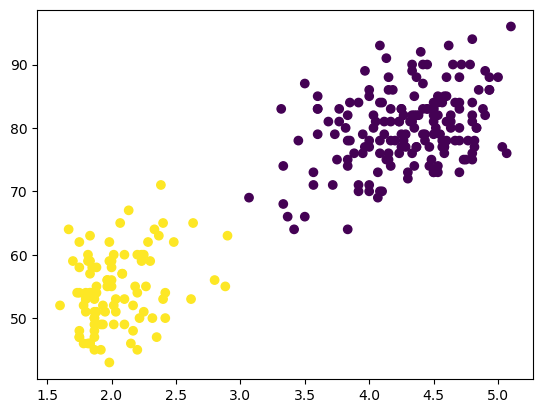

In [34]:
y_pred = gmm.predict(xnew)
plt.scatter(xnew[:,0],xnew[:,1],c = y_pred)